# Bayesian Linear Regression

> Bayesian Linear Regression module

In [ ]:
#| hide
import logging
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro

In [ ]:
#| hide
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.1')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings

plt.style.use('default')

In [ ]:
#| hide
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]

In [ ]:
#| hide
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

In [ ]:
#| hide
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

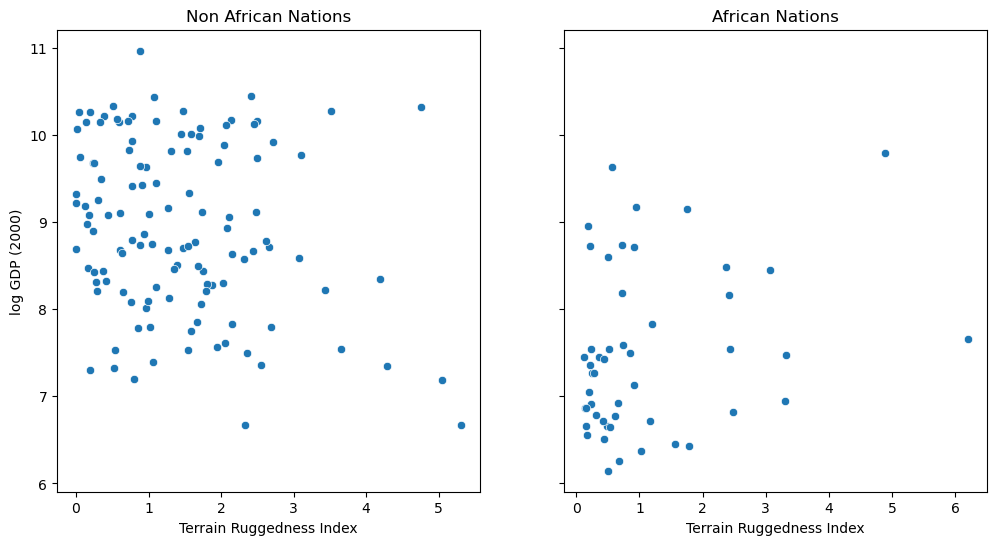

In [ ]:
#|code-fold: True
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [ ]:
#| hide
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

In [ ]:
def model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

Elbo loss: 695.2163277864456
Elbo loss: 566.6329683065414
Elbo loss: 539.5725922584534
Elbo loss: 504.6264435648918
Elbo loss: 467.88184344768524
Elbo loss: 436.07404923439026
Elbo loss: 398.4641201496124
Elbo loss: 358.5451580286026
Elbo loss: 303.2385414838791
Elbo loss: 270.1236061453819
Elbo loss: 253.93749803304672
Elbo loss: 247.9456291794777
Elbo loss: 250.44379323720932
Elbo loss: 248.22361373901367
Elbo loss: 248.04989624023438
Elbo loss: 249.36296594142914
Elbo loss: 248.020851790905
Elbo loss: 247.02174907922745
Elbo loss: 248.61388486623764
Elbo loss: 249.58516693115234


CPU times: user 6.27 s, sys: 0 ns, total: 6.27 s
Wall time: 6.26 s


Text(0, 0.5, 'ELBO loss')

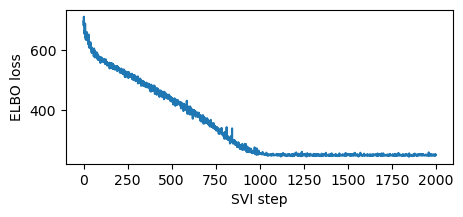

In [ ]:
%%time
pyro.clear_param_store()

# These should be reset each training loop.
auto_guide = pyro.infer.autoguide.AutoNormal(model)
adam = pyro.optim.Adam({"lr": 0.01})  # Consider decreasing learning rate.
elbo = pyro.infer.Trace_ELBO()
svi = pyro.infer.SVI(model, auto_guide, adam, elbo)

losses = []
for step in range(2000 if not smoke_test else 2):  # Consider running for more steps.
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss");

In [ ]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name).data.cpu().numpy())

AutoNormal.locs.a 9.175058
AutoNormal.scales.a 0.067621104
AutoNormal.locs.bA -1.8529075
AutoNormal.scales.bA 0.15267152
AutoNormal.locs.bR -0.19690487
AutoNormal.scales.bR 0.041917384
AutoNormal.locs.bAR 0.33121416
AutoNormal.scales.bAR 0.08399268
AutoNormal.locs.sigma -2.2478924
AutoNormal.scales.sigma 0.05665345


In [ ]:
with pyro.plate("samples", 800, dim=-1):
    samples = auto_guide(is_cont_africa, ruggedness)

gamma_within_africa = samples["bR"] + samples["bAR"]
gamma_outside_africa = samples["bR"]
offset_within_africa = samples["a"] + samples["bA"]
offset_outside_africa = samples["a"]

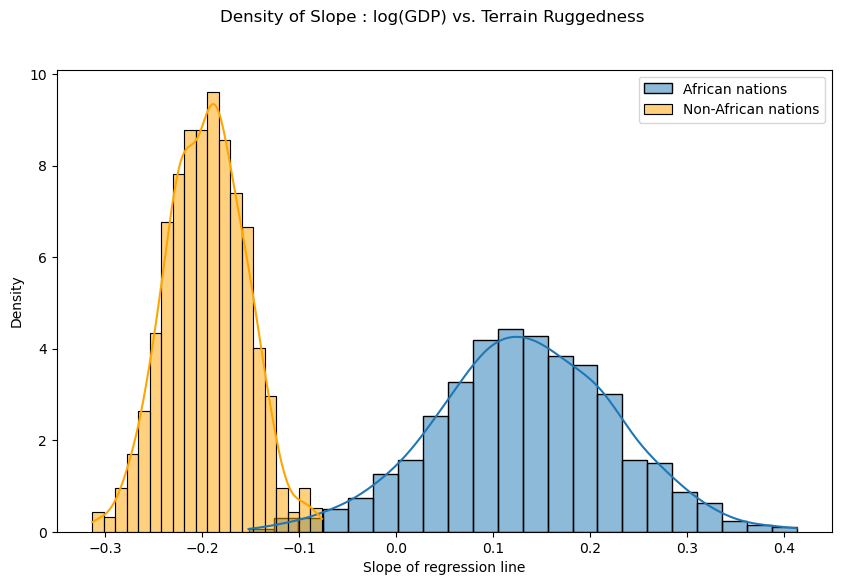

In [ ]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(gamma_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(gamma_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");
plt.xlabel("Slope of regression line")
plt.legend()
plt.show()

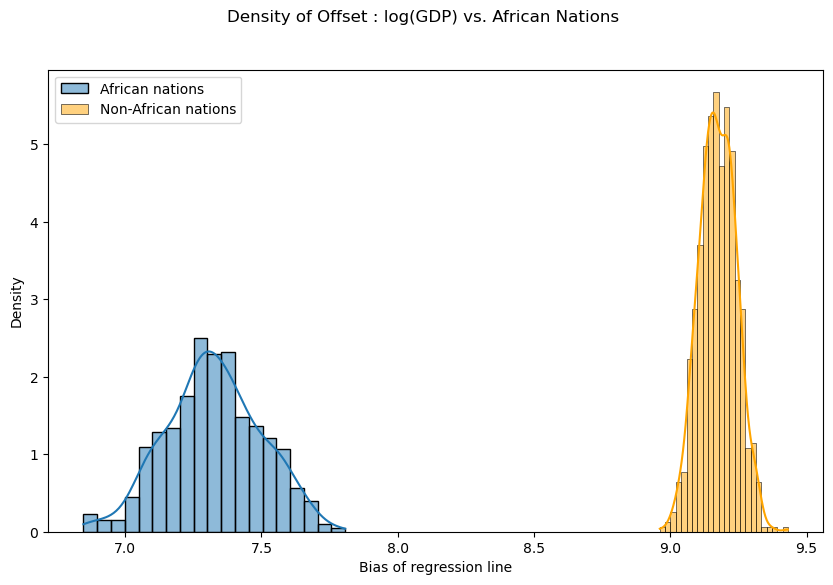

In [ ]:
fig = plt.figure(figsize=(10, 6))
sns.histplot(offset_within_africa.detach().cpu().numpy(), kde=True, stat="density", label="African nations")
sns.histplot(offset_outside_africa.detach().cpu().numpy(), kde=True, stat="density", label="Non-African nations", color="orange")
fig.suptitle("Density of Offset : log(GDP) vs. African Nations");
plt.xlabel("Bias of regression line")
plt.legend()
plt.show()

In [ ]:
predictive = pyro.infer.Predictive(model, guide=auto_guide, num_samples=800)
svi_samples = predictive(is_cont_africa, ruggedness, log_gdp=None)
svi_gdp = svi_samples["obs"]

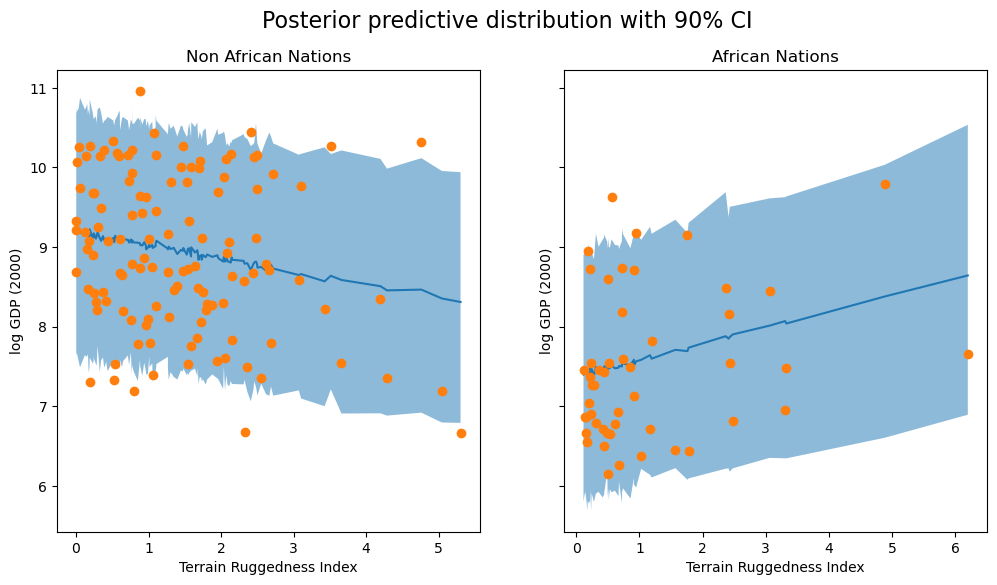

In [ ]:
predictions = pd.DataFrame({
    "cont_africa": is_cont_africa,
    "rugged": ruggedness,
    "y_mean": svi_gdp.mean(0).detach().cpu().numpy(),
    "y_perc_5": svi_gdp.kthvalue(int(len(svi_gdp) * 0.05), dim=0)[0].detach().cpu().numpy(),
    "y_perc_95": svi_gdp.kthvalue(int(len(svi_gdp) * 0.95), dim=0)[0].detach().cpu().numpy(),
    "true_gdp": log_gdp,
})
african_nations = predictions[predictions["cont_africa"] == 1].sort_values(by=["rugged"])
non_african_nations = predictions[predictions["cont_africa"] == 0].sort_values(by=["rugged"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"], non_african_nations["y_mean"])
ax[0].fill_between(non_african_nations["rugged"], non_african_nations["y_perc_5"], non_african_nations["y_perc_95"], alpha=0.5)
ax[0].plot(non_african_nations["rugged"], non_african_nations["true_gdp"], "o")
ax[0].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="Non African Nations")

ax[1].plot(african_nations["rugged"], african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"], african_nations["y_perc_5"], african_nations["y_perc_95"], alpha=0.5)
ax[1].plot(african_nations["rugged"], african_nations["true_gdp"], "o")
ax[1].set(xlabel="Terrain Ruggedness Index", ylabel="log GDP (2000)", title="African Nations");

In [ ]:
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)

Elbo loss: 5123.27234762907
Elbo loss: 833.1658895015717
Elbo loss: 634.0644181966782
Elbo loss: 565.6138790845871
Elbo loss: 549.9748696088791
Elbo loss: 531.8967778682709
Elbo loss: 514.3843936920166
Elbo loss: 509.95241755247116
Elbo loss: 501.6580073237419
Elbo loss: 490.6812038421631


CPU times: user 42.4 s, sys: 740 ms, total: 43.2 s
Wall time: 2.83 s


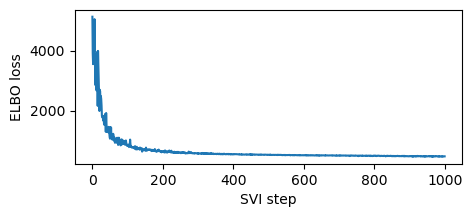

In [ ]:
%%time
pyro.clear_param_store()
mvn_guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
svi = pyro.infer.SVI(model,
                     mvn_guide,
                     pyro.optim.Adam({"lr": 0.02}),
                     pyro.infer.Trace_ELBO())

losses = []
for step in range(1000 if not smoke_test else 2):
    loss = svi.step(is_cont_africa, ruggedness, log_gdp)
    losses.append(loss)
    if step % 100 == 0:
        logging.info("Elbo loss: {}".format(loss))

plt.figure(figsize=(5, 2))
plt.plot(losses)
plt.xlabel("SVI step")
plt.ylabel("ELBO loss")

with pyro.plate("samples", 800, dim=-1):
    mvn_samples = mvn_guide(is_cont_africa, ruggedness)

mvn_gamma_within_africa = mvn_samples["bR"] + mvn_samples["bAR"]
mvn_gamma_outside_africa = mvn_samples["bR"]

# Interface note: reuse guide samples for prediction by passing them to Predictive
# via the posterior_samples keyword argument instead of passing the guide as above
assert "obs" not in mvn_samples
mvn_predictive = pyro.infer.Predictive(model, posterior_samples=mvn_samples)
mvn_predictive_samples = mvn_predictive(is_cont_africa, ruggedness, log_gdp=None)

mvn_gdp = mvn_predictive_samples["obs"]

<matplotlib.legend.Legend>

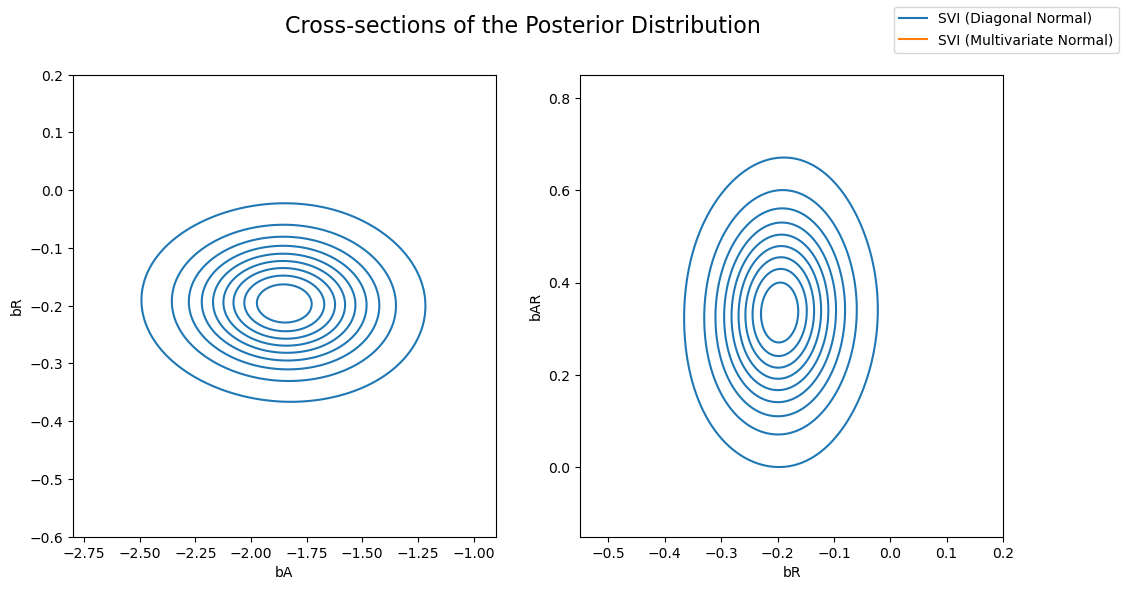

In [ ]:
svi_samples = {k: v.detach().cpu().numpy() for k, v in samples.items()}
svi_mvn_samples = {k: v.detach().cpu().numpy() for k, v in mvn_samples.items()}

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bA"], y=svi_mvn_samples["bR"], ax=axs[0], shade=True, bw_adjust=4)
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.8, -0.9), ylim=(-0.6, 0.2))

sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1],bw_adjust=4 )
sns.kdeplot(x=svi_mvn_samples["bR"], y=svi_mvn_samples["bAR"], ax=axs[1], shade=True, bw_adjust=4)
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.55, 0.2), ylim=(-0.15, 0.85))


for label, color in zip(["SVI (Diagonal Normal)", "SVI (Multivariate Normal)"], sns.color_palette()[:2]):
    plt.plot([], [],
                label=label, color=color)

fig.legend(loc='upper right')

In [ ]:
#| default_exp core
class BayesianLinearRegression():
    def __init__(self, n_inputs):
        self.n_inputs = n_inputs
        

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()